In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
import csv
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import tensorflow.keras.backend as K

Below are all of the methods: the attention layer, data loading, normalization and segmentation

In [9]:
# Define the Attention layer
class SimpleAttention(tf.keras.layers.Layer):
    def call(self, inputs):
        # Compute the sum of inputs along the last axis
        attention = tf.nn.softmax(tf.reduce_sum(inputs, axis=-1), axis=-1)
        # Expand dimensions to apply attention weights
        attention = tf.expand_dims(attention, axis=-1)
        # Weight the inputs with the attention weights
        weighted_inputs = inputs * attention
        # Sum the weighted inputs across the time steps
        output = tf.reduce_sum(weighted_inputs, axis=1)
        return output

# Function to load data
def load_data(data_dir, labels_dir, segment_length=2000, overlap=1000):
    recordings = []
    labels = []
    sample_rate = None  # Variable to store the sample rate of audio files
    
    # Read labels from the CSV file and store them in a dictionary for quick lookup
    # The labels in the original dataset are labelled 1 for healthy and -1 for unhealthy. Relabelling -1 to zero should be better for training (i think..)
    label_dict = {}
    with open(labels_dir, newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        for rows in reader:
            if rows[1] == '-1':
                label_dict[rows[0]] = 0
            else:
                label_dict[rows[0]] = 1

    print("Labels loaded successfully.")

    # Iterate over each file in the data directory
    for filename in os.listdir(data_dir):
        if filename.endswith(".wav"):
            # Read the WAV file and its sample rate
            sample_rate, data = wavfile.read(os.path.join(data_dir, filename))
            print(f"Loaded {filename} with sample rate {sample_rate} and data length {len(data)}.")

            # Normalize the audio signal to have amplitude values between -1 and 1
            normalized_data = normalize_signal(data)
            
            # Segment the normalized data and get corresponding labels for each segment. Longer signals have more segments.
            segments, segment_labels = segment_signal(normalized_data, label_dict.get(filename.split('.')[0], None), segment_length, overlap)
            print(f"Segmented {filename} into {len(segments)} segments.")
            
            recordings.extend(segments)  # Add these segments to the list of all recordings
            labels.extend(segment_labels)  # Add corresponding labels for each segment

    # Convert lists to NumPy arrays for better integration with machine learning frameworks
    recordings = np.array(recordings)
    labels = np.array(labels)

    return recordings, labels, sample_rate

# Helper functions for signal processing
def normalize_signal(signal):
    max_val = np.max(np.abs(signal))
    normalized_signal = signal / max_val
    return normalized_signal

def segment_signal(signal, label, segment_length, overlap):
    segments = []
    segment_labels = []
    step = segment_length - overlap  # Calculate the step size to create overlapping segments
    for start in range(0, len(signal) - segment_length + 1, step):
        end = start + segment_length  # Define the end of the segment
        segments.append(signal[start:end])  # Extract the segment and append it to the list
        segment_labels.append(label)  # Append the same label to the segment_labels list
    return segments, segment_labels

Data Loading

1. download the data from https://physionet.org/content/challenge-2016/1.0.0/#files
2. set data & label directory to the validation set directories

In [10]:
# Load data using the defined function
data_dir = "C:\\Downloads\\physionet\\validation"
labels_dir = "C:\\Downloads\\physionet\\validation\\REFERENCE.csv"
recordings, labels, sample_rate = load_data(data_dir, labels_dir)

Labels loaded successfully.
Loaded a0001.wav with sample rate 2000 and data length 71332.
Segmented a0001.wav into 70 segments.
Loaded a0002.wav with sample rate 2000 and data length 41657.
Segmented a0002.wav into 40 segments.
Loaded a0003.wav with sample rate 2000 and data length 61440.
Segmented a0003.wav into 60 segments.
Loaded a0004.wav with sample rate 2000 and data length 71193.
Segmented a0004.wav into 70 segments.
Loaded a0005.wav with sample rate 2000 and data length 71332.
Segmented a0005.wav into 70 segments.
Loaded a0006.wav with sample rate 2000 and data length 41518.
Segmented a0006.wav into 40 segments.
Loaded a0007.wav with sample rate 2000 and data length 71332.
Segmented a0007.wav into 70 segments.
Loaded a0008.wav with sample rate 2000 and data length 71611.
Segmented a0008.wav into 70 segments.
Loaded a0009.wav with sample rate 2000 and data length 71611.
Segmented a0009.wav into 70 segments.
Loaded a0010.wav with sample rate 2000 and data length 71472.
Segmented 

1. Conversion to NumPy Arrays
2. Reshape the input to 3D shape for Keras
3. Split data into test/train

In [11]:
# Prepare data
X = np.array(recordings).reshape((len(recordings), len(recordings[0]), 1))
y = np.array(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

2000/64-1 model

- 2000 time steps & 1 feature
- 64 neuron LSTM layer
- Attention layer
- Dense layer for bionary classification

In [12]:
# Model architecture
input_layer = Input(shape=(2000, 1))  # Assuming 2000 time steps, 1 feature per step
lstm_out = LSTM(64, return_sequences=True)(input_layer)
attention_out = SimpleAttention()(lstm_out)
output_layer = Dense(1, activation='sigmoid')(attention_out)
model = Model(inputs=[input_layer], outputs=[output_layer])

compilation and training 

In [13]:
# Compile and train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2000, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 2000, 64)            │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_attention_1 (SimpleAttention) │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 60s 755ms/step - accuracy: 0.5293 - loss: 0.6904 - val_accuracy: 0.5407 - val_loss: 0.6824
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 56s 732ms/step - accuracy: 0.5085 - loss: 0.6874 - val_accuracy: 0.5236 - val_loss: 0.6791
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 57s 740ms/step - accuracy: 0.6133 - loss: 0.6707 - val_accuracy: 0.6415 - val_loss: 0.6493
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 57s 738ms/step - accuracy: 0.6615 - loss: 0.6304 - val_accuracy: 0.6626 - val_loss: 0.6325
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 57s 736ms/step - accuracy: 0.6564 - loss: 0.6250 - val_accuracy: 0.7203 - val_loss: 0.5838
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 57s 738ms/step - accuracy: 0.6892 - loss: 0.6057 - val_accuracy: 0.6789 - val_loss: 0.6124
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 57s 738ms/step - accuracy: 0.6787 - loss: 0.6054 - val_accuracy: 0.6902 - val_loss: 0.5987
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 56s 732ms/step - accuracy: 0.5667 - loss: 0.7032 - val_accu

testing

In [7]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 33s 169ms/step - accuracy: 0.5348 - loss: 0.6927
Test Accuracy: 0.525947630405426


Plot training & validation accuracy values

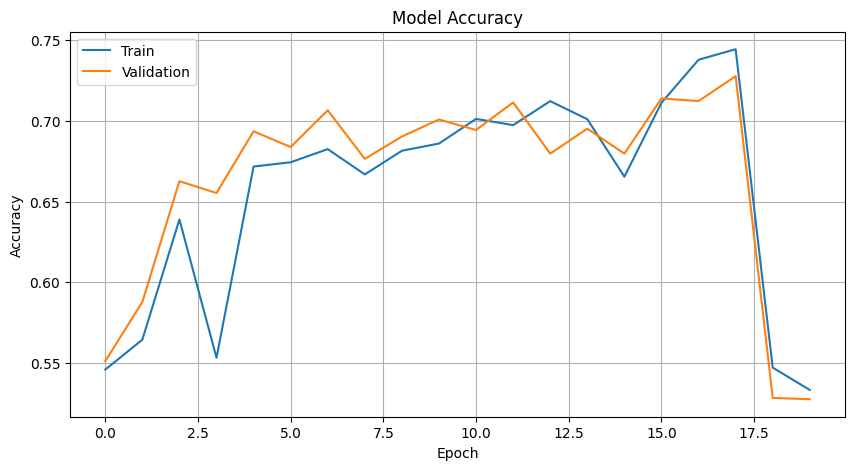

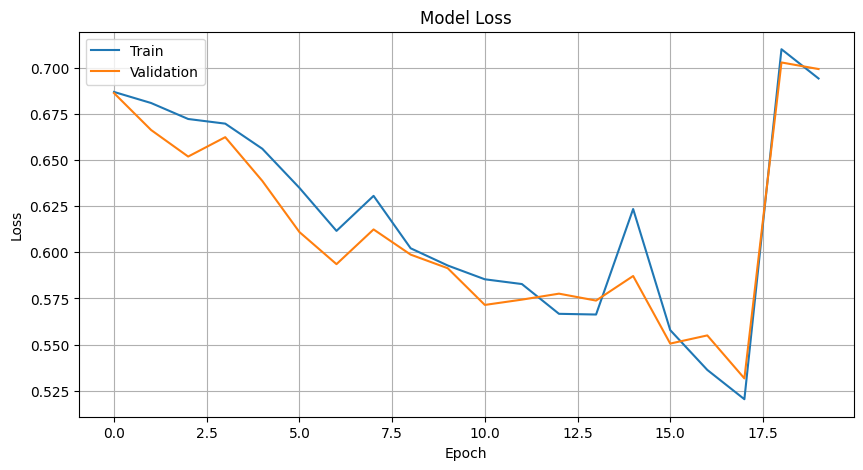

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()